In [1]:
import matplotlib as mp
from matplotlib import pyplot as pp
import numpy as np
import fcsparser
import plotly

In [2]:
# Import the metadata from the fcs files
[meta,data] = fcsparser.parse('FCS_files/tumor39/fcs/T38_Sulf_1_JR2_001.fcs', meta_data_only=False, reformat_meta=True)
#print(type(meta))
#print(meta.keys())
print(meta['_channels_'])


                             $PnN    $PnR  $PnB    $PnE  $PnV  $PnG
Channel Number                                                     
1                           FSC-A  262144    32  [0, 0]    60   1.0
2                           FSC-H  262144    32  [0, 0]    60   1.0
3                           FSC-W  262144    32  [0, 0]    60   1.0
4                           SSC-A  262144    32  [0, 0]   231   1.0
5                           SSC-H  262144    32  [0, 0]   231   1.0
6                           SSC-W  262144    32  [0, 0]   231   1.0
7                         BV421-A  262144    32  [0, 0]   461   1.0
8                         BV711-A  262144    32  [0, 0]   553   1.0
9                          FITC-A  262144    32  [0, 0]   526   1.0
10                  PerCP-Cy5-5-A  262144    32  [0, 0]   528   1.0
11                       PE-Cy7-A  262144    32  [0, 0]   522   1.0
12              Alexa Fluor 700-A  262144    32  [0, 0]   466   1.0
13                           PE-A  262144    32 

Text(0,0.5,'SSC-A')

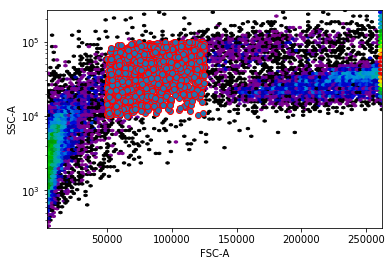

In [54]:
# All of the relevant data is in (unsurprisingly) 'data' (a variable)
# First column is cell #, first row is VarName
# You then call the data based on the parameter...
# i.e. data['FSC-A'] prints the data from the forward scatter area.
# I think you're then good to roll!

fig = pp.figure()
ax = fig.add_subplot(1, 1, 1)
# SSC-A should be log... FSC-A should be linear
# Pretty sure that all Fluorescent data should also be log

# So the fluorescent data must already be compensated, because there is a decent
# number of negative values in the there...
# Log-Log gets pissed off if you have negative and zero values, so for now take the
# absolute value and add 1 SUPER NOT GOOD TO DO FOR THE REAL DATA
pp.hexbin(abs(data['FSC-A'])+1, data['SSC-A'], bins='log',xscale='linear', yscale='log', mincnt=1, cmap='nipy_spectral')
pp.xlabel('FSC-A')
pp.ylabel('SSC-A')

# Here I just really quick plot the results from the lower cell on to this plot...
# IT WORKS
pp.scatter(fscA[:a], sscA[:a],edgecolor='red')

In [48]:
# Alright let's have our first try at gating in python...
# Here do it in a super simple manner... Just pick out a square
fscA=np.zeros(len(data['FSC-A']))
sscA=np.zeros(len(data['FSC-A']))
a=0
for i in np.arange(len(data['FSC-A'])):
    if data['FSC-A'][i] > 50000 and data['FSC-A'][i] < 125000 and data['SSC-A'][i] > 10**4 and data['SSC-A'][i] < 10**5:
        fscA[a]=data['FSC-A'][i]
        sscA[a]=data['SSC-A'][i]
        a=a+1


Text(0,0.5,'SSC-A-Gated')

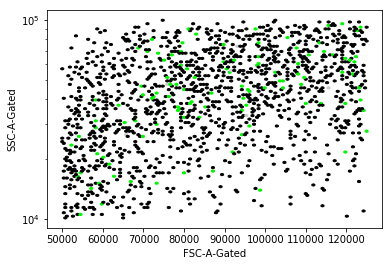

In [52]:
# Looks like it works, but it would be really nice to automatically set it to the same axis properties
# as the figure in the original graph... Problem for another day.

pp.hexbin(fscA[:a], sscA[:a], bins='log',xscale='linear', yscale='log', mincnt=1, cmap='nipy_spectral')
pp.xlabel('FSC-A-Gated')
pp.ylabel('SSC-A-Gated')

In [63]:
#Cool, now on to the Machine learning shit!!!
# Example at https://www.digitalocean.com/community/tutorials/how-to-build-a-machine-learning-classifier-in-python-with-scikit-learn
# Focuses on using Tumor data to detemine if it is benign or not via Bayesian classifier
# They do their learning with 569 tumors (holy shit) and look at 30 physical properties
import sklearn

In [72]:
# Separate section to import example breast cancer data to implement the algorithm
from sklearn.datasets import load_breast_cancer

# Load dataset
data = load_breast_cancer()
# Let's look at the individual attributes in this dataset.
label_names = data['target_names']
labels = data['target']
feature_names = data['feature_names']
features = data['data']



In [73]:
# Split the data in to test and training sets
from sklearn.model_selection import train_test_split
train, test, train_labels, test_labels = train_test_split(features, labels, test_size=0.33, random_state=42)
# Should be able to somehow determine which axes the test and training data are split along...
# Additionally, the test_size is what percentage of the data you want to set aside for training
# random_state is presumably a seed of some sort for choosing your portion of the data randomly


In [74]:
# Naive Bayes classification is for two-state, so may actually not be ideal in this case.
# But import it anyway, go through the training and see how it's done.
from sklearn.naive_bayes import GaussianNB

# Initialize our classifier
gnb = GaussianNB()

# Train our classifier (seems like they do it on a subset of the 30 variables...)
# Isn't it better to do it on a subset of the 569 data points?
model = gnb.fit(train, train_labels)

# Then, make some predictions
# Apparently this already gives out the 
preds = gnb.predict(test)
print(preds)
# Note that my output is the exact same as the one on the website, so that
# random seed (understandably) makes the algorithm deterministic

[1 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0
 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0
 1 1 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0
 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0
 0 1 1]


In [75]:
# Then, get at the accuracy of the model (how good did you do)
from sklearn.metrics import accuracy_score

# Evaluate accuracy
print(accuracy_score(test_labels, preds))

0.9414893617021277
